<a href="https://colab.research.google.com/github/ufukhurriyetoglu/vector-normalization-for-vector-search/blob/main/model_fine_tuning_for_semantic_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install txtai[pipeline,similarity] datasets

In [2]:
import os
import random
import torch

import numpy as np

from torch import nn
from torch.nn import CrossEntropyLoss

from transformers import AutoConfig, AutoTokenizer
from transformers.modeling_outputs import SequenceClassifierOutput

def seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

class Simple(nn.Module):
    def __init__(self, vocab, dimensions, labels):
        super().__init__()

        self.config = AutoConfig.from_pretrained("bert-base-uncased")
        self.labels = labels

        self.embedding = nn.EmbeddingBag(vocab, dimensions)
        self.classifier = nn.Linear(dimensions, labels)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.classifier.weight.data.uniform_(-initrange, initrange)
        self.classifier.bias.data.zero_()

    def forward(self, input_ids=None, labels=None, **kwargs):
        embeddings = self.embedding(input_ids)
        logits = self.classifier(embeddings)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
        )

In [3]:
from datasets import load_dataset

from transformers import AutoTokenizer

from txtai.models import Registry
from txtai.pipeline import HFTrainer, Labels

ds = load_dataset("emotion")

# Set seed for reproducibility
seed()

# Define model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = Simple(tokenizer.vocab_size, 128, len(ds["train"].unique("label")))

# Train model
train = HFTrainer()
model, tokenizer = train((model, tokenizer), ds["train"], per_device_train_batch_size=8, learning_rate=1e-3, num_train_epochs=15, logging_steps=10000)

# Register custom model to fully support pipelines
Registry.register(model)

# Create labels pipeline using PyTorch model
labels = Labels((model, tokenizer), dynamic=False)

# Determine accuracy on validation set
results = [row["label"] == labels(row["text"])[0][0] for row in ds["validation"]]
print("Accuracy = ", sum(results) / len(ds["validation"]))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
10000,1.016600
20000,0.284700
30000,0.152700


Accuracy =  0.8845


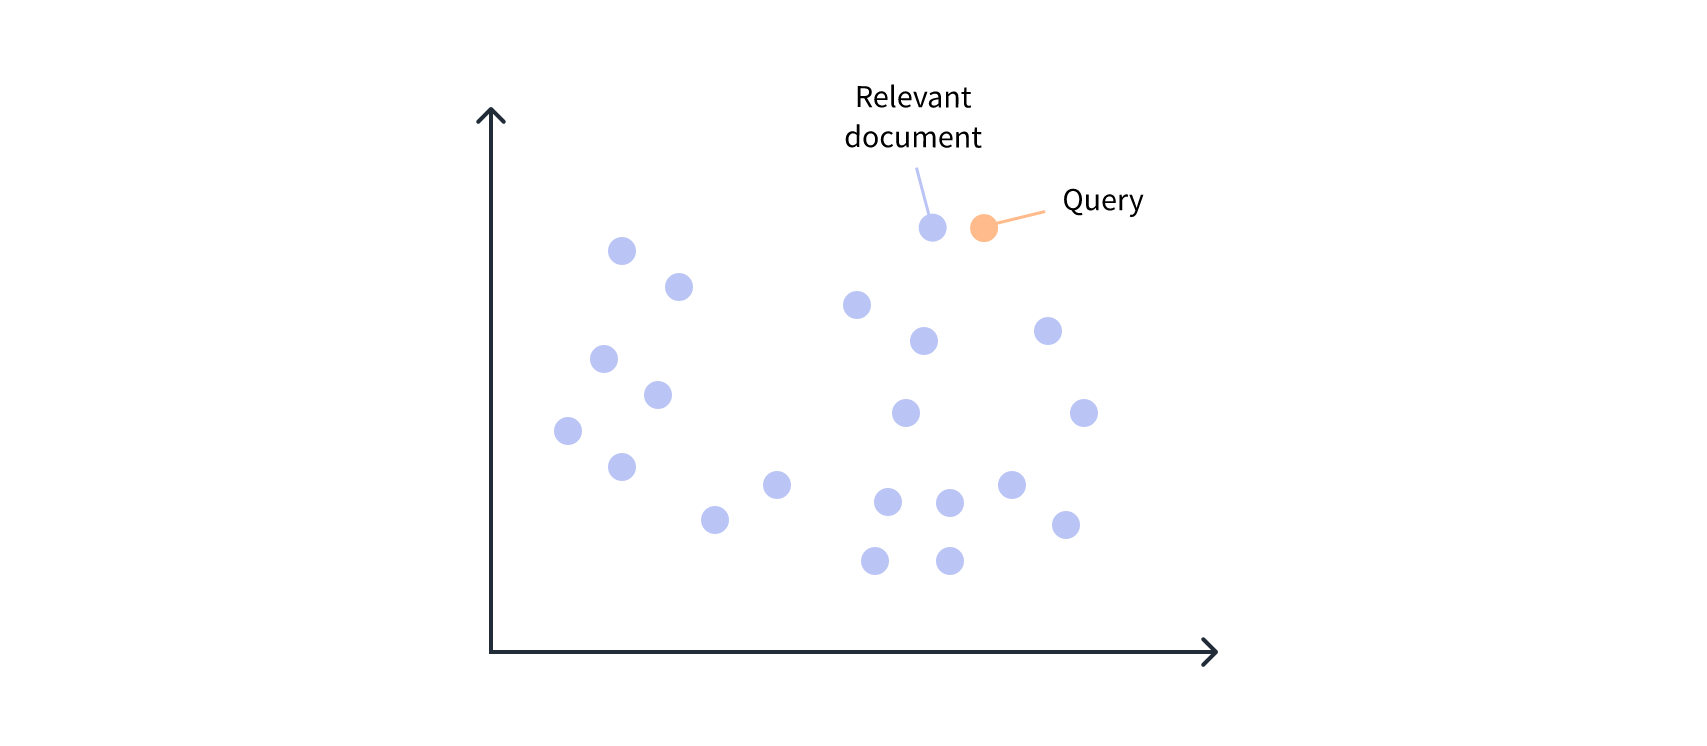

In [5]:
class SimpleEmbeddings(nn.Module):
    def __init__(self, embeddings):
        super().__init__()

        self.embeddings = embeddings

    def forward(self, input_ids=None, **kwargs):
        return (self.embeddings(input_ids),)

In [6]:
from txtai.embeddings import Embeddings

data = ["Glad you found it", "Happy to see you", "What a cute picture",
        "I'm angry", "That's upsetting", "That is so troubling",
        "A shocking development right now", "Never thought I would see that", "Didn't see that coming"]

embeddings = Embeddings({"method": "pooling", "path": SimpleEmbeddings(model.embedding),
                         "tokenizer": "bert-base-uncased"})

# Create an index for the list of text
embeddings.index([(uid, text, None) for uid, text in enumerate(data)])

# Run an embeddings search for each query
for query in ("happy thoughts", "mad", "wow"):
    print(query)

    # Print top 3 results
    for uid, score in embeddings.search(query, 3):
      print(data[uid], score)

    print()

happy thoughts
What a cute picture 0.6844580769538879
Glad you found it 0.6749856472015381
Happy to see you 0.6504136323928833

mad
I'm angry 0.7777423858642578
That is so troubling 0.7067034244537354
That's upsetting 0.29688912630081177

wow
Never thought I would see that 0.4430314600467682
Didn't see that coming 0.41248998045921326
A shocking development right now 0.3922528028488159



In [7]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Train the model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter=250))
])

pipeline.fit(ds["train"]["text"], ds["train"]["label"])

# Determine accuracy on validation set
results = pipeline.predict(ds["validation"]["text"])
labels = ds["validation"]["label"]

results = [results[x] == label for x, label in enumerate(labels)]
print("Accuracy =", sum(results) / len(ds["validation"]))

Accuracy = 0.8595


In [8]:
from txtai.pipeline import MLOnnx, Similarity

def tokenize(inputs, **kwargs):
    if isinstance(inputs, str):
        inputs = [inputs]

    return {"input_ids": [[x] for x in inputs]}

# Export to ONNX
onnx = MLOnnx()
skmodel = onnx(pipeline)

# Load models into similarity pipeline
similarity = Similarity((skmodel, tokenize), dynamic=False)

# Add labels to model
similarity.pipeline.model.config.id2label = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
similarity.pipeline.model.config.label2id = dict((v, k) for k, v in similarity.pipeline.model.config.id2label.items())

# Run an embeddings search for each query
for query in ("joy", "anger", "surprise"):
    print(query)

    # Print top 3 results
    for uid, score in similarity(query, data, None)[:3]:
      print(data[uid], score)

    print()

joy
What a cute picture 0.9270938634872437
Glad you found it 0.9024074077606201
Happy to see you 0.841560959815979

anger
I'm angry 0.9789674878120422
Didn't see that coming 0.2017315775156021
That's upsetting 0.16478465497493744

surprise
That is so troubling 0.04045116901397705
That's upsetting 0.03875379264354706
Never thought I would see that 0.030830107629299164



In [9]:
import time

from txtai.pipeline import Labels

# Create labels instances per model type
tflabels = Labels(train("microsoft/xtremedistil-l6-h384-uncased", ds["train"], logging_steps=2000), dynamic=False)

thlabels = Labels((model, tokenizer), dynamic=False)
thlabels.pipeline.model.config.id2label = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}

sklabels = Labels((skmodel, tokenize), dynamic=False)
sklabels.pipeline.model.config.id2label = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}

# Test inputs
inputs = ds["test"]["text"]
print("Testing speed of %d items" % len(inputs))

start = time.time()
tflabels(inputs)
print("Transformers time =", time.time() - start)

start = time.time()
thlabels(inputs)
print("PyTorch time =", time.time() - start)

start = time.time()
sklabels(inputs, multilabel=None)
print("TF-IDF + Logistic Regression time =", time.time() - start)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/xtremedistil-l6-h384-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


KeyboardInterrupt: ignored